## RNN LSTM Text Classificaiton model

### Dependencies and Libraries

In [25]:
import os
from collections import Counter
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# from google.colab import drive
# drive.mount('/content/drive')
# os.chdir('drive/MyDrive/School Work/CS4248/News Labelling Project')

### Reading in data into pd dataframes, data viewing

In [26]:
# Read CSV file in
train_path = './raw_data/fulltrain.csv'
test_path = './raw_data/balancedtest.csv'
df = pd.read_csv(train_path, header=None)

print(type(df))

# Samples, number of columns, 0 = labels, column 1 = text
print('Total rows, Total Columns: ' + str(df.shape))
df.sample(5) # Random sample values to see

<class 'pandas.core.frame.DataFrame'>
Total rows, Total Columns: (48854, 2)


,0,1
8527,1,"Speaking at an HBO press junket Monday, acclai..."
15477,2,"Obama Support Gives Cop Serious Attitude, Imme..."
29345,3,10 Reasons Why The Global Economy Is About To ...
5515,1,Judging by his call of Tuesday's third race at...
8786,1,A new study published Friday by scientists at ...


In [27]:
# Get number of labels for each task
classes = ['Satire', 'Hoax', 'Propaganda', 'Reliable News']
label_numbers = [1,2,3,4]

for label in label_numbers:
    print(classes[label-1] + ': ' + str((df[0] == label).sum()))
print(df[0].value_counts())

Satire: 14047
Hoax: 6942
Propaganda: 17870
Reliable News: 9995
3    17870
1    14047
4     9995
2     6942
Name: 0, dtype: int64


### Reading in testing set

In [28]:
test_df = pd.read_csv(test_path, header=None)

# Samples, number of columns, 0 = labels, column 1 = text
print('Total rows, Total Columns: ' + str(test_df))
test_df.sample(5) # Random sample values to see

Total rows, Total Columns:       0                                                  1
0     1  When so many actors seem content to churn out ...
1     1   In what football insiders are calling an unex...
2     1  In a freak accident following Game 3 of the N....
3     1  North Koreas official news agency announced to...
4     1  The former Alaska Governor Sarah Palin would b...
...  ..                                                ...
2995  4  The Air Force mistakenly gave rival companies ...
2996  4  The United Nations climate chief on Friday cha...
2997  4  River Plate midfielder Diego Buonanotte has un...
2998  4  Lawmakers were on the brink Tuesday of exempti...
2999  4  The Pentagon, which is processing bids on a ne...

[3000 rows x 2 columns]


,0,1
1138,2,ISIS Attacks Iraqs Largest Refinery With Morta...
613,1,"Its time to celebrate, because the U.S. surgeo..."
1051,2,[Watch] Judge Napolitano On How The Benghazi C...
967,2,Emails Show True Role Gruber Took In ObamaCare...
899,2,Trump Official - If GOP Steals Nomination Here...


In [29]:
# Get number of labels for each task
classes = ['Satire', 'Hoax', 'Propaganda', 'Reliable News']
label_numbers = [1,2,3,4]

for label in label_numbers:
    print(classes[label-1] + ': ' + str((test_df[0] == label).sum()))
print(test_df[0].value_counts())

Satire: 750
Hoax: 750
Propaganda: 750
Reliable News: 750
1    750
2    750
3    750
4    750
Name: 0, dtype: int64


### Count number of unique words in the entire dataset

In [30]:
# Count number of unique words
def unique_word_counter(texts):
    count = Counter() # Dictionary type
    # Access an entire string
    for text in texts:
        # Split each string into individual words separated by whitespace
        for word in text.split():
            count[word] += 1
    return count

In [31]:
# Run counter
counts = unique_word_counter(df[1])
unique_words_count = len(counts)
print('Number of unique words: ' + str(unique_words_count))
print('Most Common Words:')
counts.most_common(10)

Number of unique words: 677571
Most Common Words:


[('the', 1356038),
 ('to', 729997),
 ('of', 705981),
 ('and', 637368),
 ('a', 522053),
 ('in', 429077),
 ('that', 324277),
 ('is', 303340),
 ('for', 227190),
 ('on', 179343)]

### Prepare datasets, convert into numpy format for Keras Model

In [32]:
X_train = df[1].to_numpy()
y_train = df[0].to_numpy()

X_test = test_df[1].to_numpy()
y_test = test_df[0].to_numpy()

y_train = pd.get_dummies(df[0]).values
y_test = pd.get_dummies(test_df[0]).values
print(type(y_train))
print(type(y_test))

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(48854,) (3000,)
(48854, 4) (3000, 4)


In [ ]:
y_train

In [ ]:
y_test

### Tokenise words into numbers
- Each word will be assigned a specific number, according to how many unique words we have
- Inspired from this [Youtube Video](https://www.youtube.com/watch?v=kxeyoyrf2cM&ab_channel=PythonEngineer)

In [33]:
# Each string is turned into a sequence of integers
tokenizer = Tokenizer(num_words=unique_words_count)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

### Pad sequences to a common length

In [34]:
# Determine minimum number of words in a sequence 65218, 

padding_length = 1000

length_count = 0
for item in X_train:
    length = len(item)
    if length > padding_length:
        length_count += 1
print('Number of texts > word length: ' + str(length_count))

Number of texts > word length: 7057


In [35]:
X_train = pad_sequences(X_train, maxlen=padding_length, padding="post", truncating="post")
X_test = pad_sequences(X_test, maxlen=padding_length, padding="post", truncating="post")

# Ensure padded shape of dimension
X_train.shape, X_test.shape

((48854, 1000), (3000, 1000))

In [36]:
X_train.shape[1]

1000

### Load model for evaluation

In [37]:
from tensorflow.python.client import device_lib
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

if tf.test.gpu_device_name():
    print('GPU found')
else:
    print("No GPU found")
print(device_lib.list_local_devices())

No GPU found
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7106019772943598602
xla_global_id: -1
]


In [49]:
from keras.models import load_model
model = load_model('./TrainedModels/RNN_LSTM_RawText_9.h5') # This is the better model

predictions = model.predict(X_test)

In [50]:
predictions

array([[0.4155762 , 0.18713239, 0.0829214 , 0.31437004],
       [0.41569602, 0.18708627, 0.08269119, 0.31452644],
       [0.4158158 , 0.18703996, 0.08246171, 0.31468254],
       ...,
       [0.41584736, 0.18702768, 0.0824011 , 0.3147238 ],
       [0.41287503, 0.18810695, 0.08813528, 0.3108828 ],
       [0.41485834, 0.18740335, 0.08430091, 0.3134375 ]], dtype=float32)

In [51]:
len(predictions)

3000

In [52]:
prediction_labels = []
for prediction in predictions:
    prediction_labels.append(np.argmax(prediction))
prediction_labels[0:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [53]:
actual_labels = []
for label in y_test:
    actual_labels.append(np.argmax(label))
actual_labels[0:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [54]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

def score_model(predictions, target_value):
    score = f1_score(target_value, predictions, average='macro')
    print('F1 score = {}'.format(score))
    accuracy = accuracy_score(target_value, predictions)
    print('Accuracy = {}'.format(accuracy))
    precision = precision_score(target_value, predictions, average='micro')
    print('Precision = {}'.format(precision))
    print()

    # Print confusion matrix
def print_confusion_matrix(predictions, true_labels):
    cm = confusion_matrix(true_labels, predictions)
    cm_plot = ConfusionMatrixDisplay(confusion_matrix = cm)
    cm_plot.plot()

classes = ['Satire', 'Hoax', 'Propaganda', 'Reliable News']

In [55]:
score_model(prediction_labels, actual_labels)

F1 score = 0.31583626194774234
Accuracy = 0.42433333333333334
Precision = 0.42433333333333334



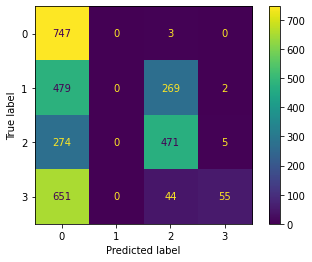

In [56]:
print_confusion_matrix(prediction_labels, actual_labels)

In [57]:
sequence_length = padding_length
vector_dimensions = 100
is_preprocessed_text = False

print('Sequence length: ' + str(sequence_length))
print('Embedding Vector Dimensions: ' + str(vector_dimensions))
print('Is clean text: ' + str(is_preprocessed_text))

Sequence length: 1000
Embedding Vector Dimensions: 100
Is clean text: False
